In [1]:
%pip install --force-reinstall -v "kagglehub==0.4.3"

Using pip 24.1.2 from /usr/local/lib/python3.12/dist-packages/pip (python 3.12)
  Obtaining dependency information for kagglehub==0.4.3 from https://files.pythonhosted.org/packages/63/82/87c9ea391564debad2cf9828fe3afd7777145f3650a65fe124893d8f3008/kagglehub-0.4.3-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 3.7 MB/s eta 0:00:00
  Obtaining dependency information for kagglesdk<1.0,>=0.1.14 from https://files.pythonhosted.org/packages/1c/d8/71a8b9115ed2cf8b487c8976e66678311e82c73980e103eda15623abd6a5/kagglesdk-0.1.15-py3-none-any.whl.metadata
  Obtaining dependency information for packaging from https://files.pythonhosted.org/packages/b7/b9/c538f279a4e237a006a2c98387d081e9eb060d203d8ed34467cc0f0b9b53/packaging-26.0-py3-none-any.whl.metadata
  Obtaining dependency information for pyyaml from https://files.pythonhosted.org/packages/8b/9d/b3589d3877982d4f2329302ef98a8026e7f4443c765c46cfecc8858c6b4b/pyyaml-6.0.3-cp312-cp312-manylinux2014_x86_64.manylin

In [2]:
import kagglehub
kagglehub.login()


In [3]:
data = kagglehub.competition_download('shift-guard-10-robust-image-classification-challenge')
data

'/root/.cache/kagglehub/competitions/shift-guard-10-robust-image-classification-challenge'

In [4]:
src_dir = "/root/.cache/kagglehub/competitions/shift-guard-10-robust-image-classification-challenge/"

# ShiftGuard10: Robust Image Classification

## Project Overview
- **Task**: Classify 32×32 RGB images into 10 classes
- **Classes**: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck
- **Metric**: Macro F1 Score
- **Model**: CNN trained from scratch (no pretrained weights)

In [7]:
import os
import numpy as np 
import pandas as pd 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import random

# Set seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True  # Safe for fixed-size 32x32 inputs, faster on T4

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

Using device: cuda
GPU: Tesla T4
GPU Memory: 14.7 GB


## 1. Data Loading & Exploration

In [8]:
# Load labels and class names
train_labels = pd.read_csv(src_dir + 'train_labels.csv')
sample_submission = pd.read_csv(src_dir + 'sample_submission.csv')

# Read class names
with open(src_dir + 'classes.txt', 'r') as f:
    class_names = [line.strip() for line in f.readlines()]

print(f"Number of classes: {len(class_names)}")
print(f"Class names: {class_names}")
print(f"Training samples: {len(train_labels)}")
print(f"Test samples: {len(sample_submission)}")

# Create label-to-index and index-to-label mappings
label_to_idx = {name: idx for idx, name in enumerate(class_names)}
idx_to_label = {idx: name for idx, name in enumerate(class_names)}

print(f"\nLabel to index mapping: {label_to_idx}")

# Check class distribution
print("\nClass distribution in training set:")
print(train_labels['label'].value_counts().sort_index())

Number of classes: 10
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Training samples: 29400
Test samples: 7600

Label to index mapping: {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}

Class distribution in training set:
label
airplane      5000
automobile    5000
bird          5000
cat           5000
deer          4000
dog           4000
frog           500
horse          500
ship           300
truck          100
Name: count, dtype: int64


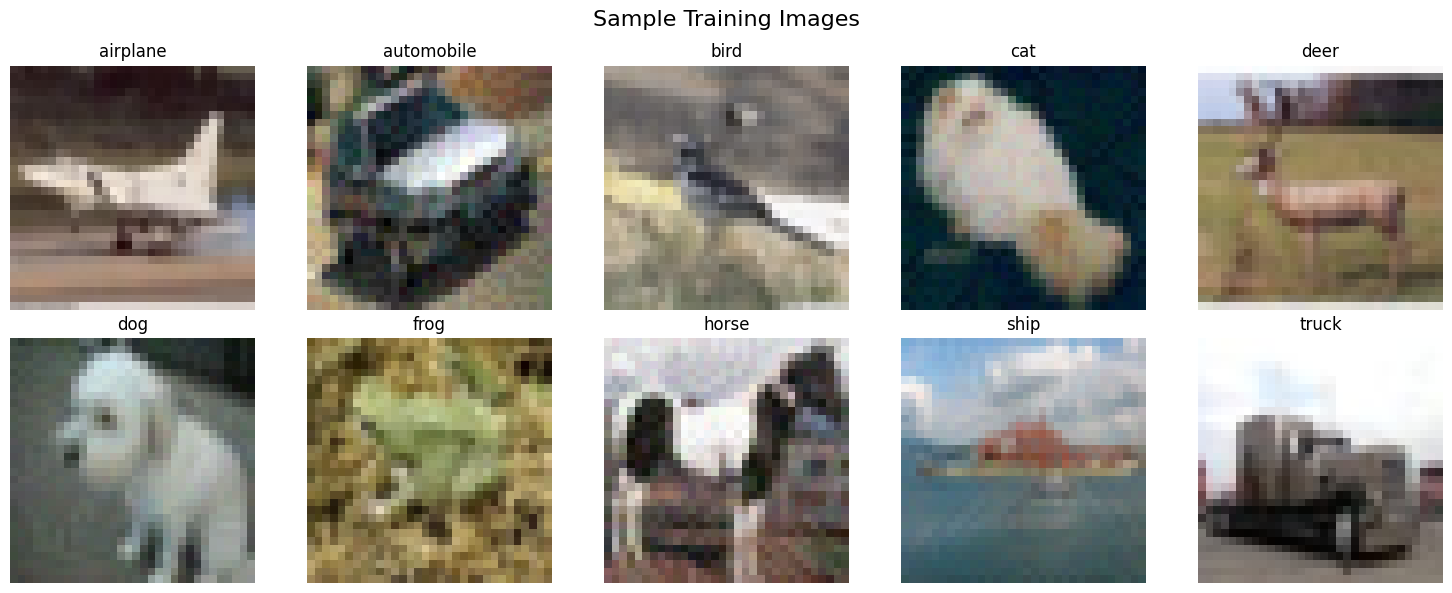

In [9]:
# Visualize some training images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Sample Training Images', fontsize=16)

for i, class_name in enumerate(class_names):
    row, col = i // 5, i % 5
    # Get one sample from this class
    sample_id = train_labels[train_labels['label'] == class_name].iloc[0]['id']
    img_path = os.path.join(src_dir, 'train_images', f'{sample_id:06d}.png')
    img = Image.open(img_path)
    axes[row, col].imshow(img)
    axes[row, col].set_title(class_name)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

## 2. Dataset & Data Augmentation

In [10]:
class ShiftGuardDataset(Dataset):
    """Custom Dataset for ShiftGuard10 competition."""
    
    def __init__(self, image_dir, labels_df=None, label_to_idx=None, transform=None):
        """
        Args:
            image_dir: Path to image directory
            labels_df: DataFrame with 'id' and 'label' columns (None for test set)
            label_to_idx: Dict mapping label names to indices
            transform: Torchvision transforms
        """
        self.image_dir = image_dir
        self.labels_df = labels_df
        self.label_to_idx = label_to_idx
        self.transform = transform
        
        if labels_df is not None:
            self.image_ids = labels_df['id'].values
            self.labels = labels_df['label'].values
        else:
            # Test set: get all image files sorted
            self.image_ids = sorted([
                int(f.split('.')[0]) for f in os.listdir(image_dir) 
                if f.endswith('.png')
            ])
            self.labels = None
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_path = os.path.join(self.image_dir, f'{img_id:06d}.png')
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        if self.labels is not None:
            label = self.label_to_idx[self.labels[idx]]
            return image, label, img_id
        else:
            return image, img_id


# Define transforms
# Training: with data augmentation for robustness
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2470, 0.2435, 0.2616]),
    transforms.RandomErasing(p=0.25, scale=(0.02, 0.2)),
])

# Validation/Test: no augmentation
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2470, 0.2435, 0.2616]),
])

print("Transforms defined successfully.")

Transforms defined successfully.


In [11]:
# Create train/validation split (90% train, 10% validation)
VAL_RATIO = 0.1
num_val = int(len(train_labels) * VAL_RATIO)
num_train = len(train_labels) - num_val

# Stratified split: shuffle and split while trying to maintain class distribution
train_labels_shuffled = train_labels.sample(frac=1, random_state=SEED).reset_index(drop=True)
train_df = train_labels_shuffled.iloc[:num_train].reset_index(drop=True)
val_df = train_labels_shuffled.iloc[num_train:].reset_index(drop=True)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"\nTraining class distribution:")
print(train_df['label'].value_counts().sort_index())
print(f"\nValidation class distribution:")
print(val_df['label'].value_counts().sort_index())

# Create datasets
train_dir = os.path.join(src_dir, 'train_images')
test_dir = os.path.join(src_dir, 'test_images')

train_dataset = ShiftGuardDataset(train_dir, train_df, label_to_idx, train_transform)
val_dataset = ShiftGuardDataset(train_dir, val_df, label_to_idx, val_transform)
test_dataset = ShiftGuardDataset(test_dir, labels_df=None, transform=val_transform)

# Create data loaders
BATCH_SIZE = 128

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                          num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                        num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                         num_workers=2, pin_memory=True)

print(f"\nDataLoaders created successfully.")
print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}, Test batches: {len(test_loader)}")

Training samples: 26460
Validation samples: 2940

Training class distribution:
label
airplane      4493
automobile    4507
bird          4498
cat           4536
deer          3565
dog           3602
frog           457
horse          453
ship           262
truck           87
Name: count, dtype: int64

Validation class distribution:
label
airplane      507
automobile    493
bird          502
cat           464
deer          435
dog           398
frog           43
horse          47
ship           38
truck          13
Name: count, dtype: int64

DataLoaders created successfully.
Train batches: 207, Val batches: 23, Test batches: 60


## 3. Model Architecture — Custom CNN (ResNet-style from scratch)

A custom CNN with residual connections, batch normalization, and dropout.  
Designed for 32×32 input images with 10 output classes. Trained entirely from scratch.

In [12]:
class ResidualBlock(nn.Module):
    """Residual block with two conv layers and skip connection."""
    
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, 
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Skip connection: identity if dimensions match, else 1x1 conv
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, 
                          stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ShiftGuardCNN(nn.Module):
    """
    Custom ResNet-style CNN for 32x32 image classification.
    Architecture: Initial Conv -> 4 Residual Stages -> Global Avg Pool -> FC
    """
    
    def __init__(self, num_classes=10):
        super(ShiftGuardCNN, self).__init__()
        
        # Initial convolution layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        # Residual stages (2 blocks each, progressively increasing channels)
        # Stage 1: 64 channels, 32x32
        self.stage1 = self._make_stage(64, 64, num_blocks=2, stride=1)
        # Stage 2: 128 channels, 16x16
        self.stage2 = self._make_stage(64, 128, num_blocks=2, stride=2)
        # Stage 3: 256 channels, 8x8
        self.stage3 = self._make_stage(128, 256, num_blocks=2, stride=2)
        # Stage 4: 512 channels, 4x4
        self.stage4 = self._make_stage(256, 512, num_blocks=2, stride=2)
        
        # Global average pooling + classifier
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(512, num_classes)
        
        # Initialize weights
        self._initialize_weights()
    
    def _make_stage(self, in_channels, out_channels, num_blocks, stride):
        layers = [ResidualBlock(in_channels, out_channels, stride)]
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.stage1(out)
        out = self.stage2(out)
        out = self.stage3(out)
        out = self.stage4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        out = self.fc(out)
        return out


# Create model
model = ShiftGuardCNN(num_classes=10).to(device)

# Print model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model: ShiftGuardCNN")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"\nModel architecture:\n{model}")

Model: ShiftGuardCNN
Total parameters: 11,173,962
Trainable parameters: 11,173,962

Model architecture:
ShiftGuardCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (stage1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_

## 4. Training Pipeline

Using:
- **Optimizer**: SGD with momentum and weight decay (Nesterov)
- **Scheduler**: Cosine Annealing with warm restarts
- **Loss**: Cross-Entropy
- **Metric**: Macro F1 Score on validation set

In [13]:
# Hyperparameters
NUM_EPOCHS = 100
LEARNING_RATE = 0.1
MOMENTUM = 0.9
WEIGHT_DECAY = 5e-4

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer: SGD with Nesterov momentum
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, 
                      momentum=MOMENTUM, weight_decay=WEIGHT_DECAY, nesterov=True)

# Learning rate scheduler: Cosine Annealing
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-5)

print(f"Optimizer: SGD (lr={LEARNING_RATE}, momentum={MOMENTUM}, weight_decay={WEIGHT_DECAY})")
print(f"Scheduler: CosineAnnealingLR (T_max={NUM_EPOCHS})")
print(f"Loss: CrossEntropyLoss")
print(f"Epochs: {NUM_EPOCHS}")

Optimizer: SGD (lr=0.1, momentum=0.9, weight_decay=0.0005)
Scheduler: CosineAnnealingLR (T_max=100)
Loss: CrossEntropyLoss
Epochs: 100


In [14]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch and return average loss and accuracy."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    for images, labels, _ in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    epoch_f1 = f1_score(all_labels, all_preds, average='macro')
    
    return epoch_loss, epoch_acc, epoch_f1


def validate(model, val_loader, criterion, device):
    """Validate and return loss, accuracy, and macro F1."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels, _ in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    epoch_f1 = f1_score(all_labels, all_preds, average='macro')
    
    return epoch_loss, epoch_acc, epoch_f1


print("Training and validation functions defined.")

Training and validation functions defined.


In [15]:
# Training loop
print("=" * 70)
print(f"Starting training for {NUM_EPOCHS} epochs on {device}")
print("=" * 70)

# Track metrics
history = {
    'train_loss': [], 'train_acc': [], 'train_f1': [],
    'val_loss': [], 'val_acc': [], 'val_f1': [],
    'lr': []
}

best_val_f1 = 0.0
best_epoch = 0

for epoch in range(1, NUM_EPOCHS + 1):
    # Train
    train_loss, train_acc, train_f1 = train_one_epoch(
        model, train_loader, criterion, optimizer, device
    )
    
    # Validate
    val_loss, val_acc, val_f1 = validate(model, val_loader, criterion, device)
    
    # Get current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    
    # Step scheduler
    scheduler.step()
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_f1'].append(train_f1)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)
    history['lr'].append(current_lr)
    
    # Save best model based on validation Macro F1
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_model.pth')
    
    # Print progress every 5 epochs or at the end
    if epoch % 5 == 0 or epoch == 1 or epoch == NUM_EPOCHS:
        print(f"Epoch [{epoch:3d}/{NUM_EPOCHS}] | "
              f"LR: {current_lr:.6f} | "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%, F1: {train_f1:.4f} | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%, F1: {val_f1:.4f}"
              f"{' *BEST*' if epoch == best_epoch else ''}")

print("=" * 70)
print(f"Training complete! Best Val Macro F1: {best_val_f1:.4f} at epoch {best_epoch}")
print("=" * 70)

Starting training for 100 epochs on cuda
Epoch [  1/100] | LR: 0.100000 | Train Loss: 2.1563, Acc: 32.00%, F1: 0.1860 | Val Loss: 1.4459, Acc: 46.33%, F1: 0.2703 *BEST*
Epoch [  5/100] | LR: 0.099606 | Train Loss: 1.1536, Acc: 57.94%, F1: 0.3734 | Val Loss: 1.0880, Acc: 61.90%, F1: 0.4110 *BEST*
Epoch [ 10/100] | LR: 0.098015 | Train Loss: 0.8891, Acc: 68.39%, F1: 0.5062 | Val Loss: 0.8874, Acc: 69.69%, F1: 0.5200
Epoch [ 15/100] | LR: 0.095242 | Train Loss: 0.7700, Acc: 72.58%, F1: 0.5632 | Val Loss: 0.8433, Acc: 71.26%, F1: 0.5623
Epoch [ 20/100] | LR: 0.091355 | Train Loss: 0.7034, Acc: 75.03%, F1: 0.5938 | Val Loss: 0.7386, Acc: 74.05%, F1: 0.5381
Epoch [ 25/100] | LR: 0.086450 | Train Loss: 0.6608, Acc: 76.41%, F1: 0.6160 | Val Loss: 0.7173, Acc: 76.12%, F1: 0.6080
Epoch [ 30/100] | LR: 0.080647 | Train Loss: 0.6195, Acc: 77.96%, F1: 0.6455 | Val Loss: 0.6761, Acc: 77.14%, F1: 0.6343
Epoch [ 35/100] | LR: 0.074090 | Train Loss: 0.5719, Acc: 79.34%, F1: 0.6771 | Val Loss: 0.6061, A

## 5. Training Curves Visualization

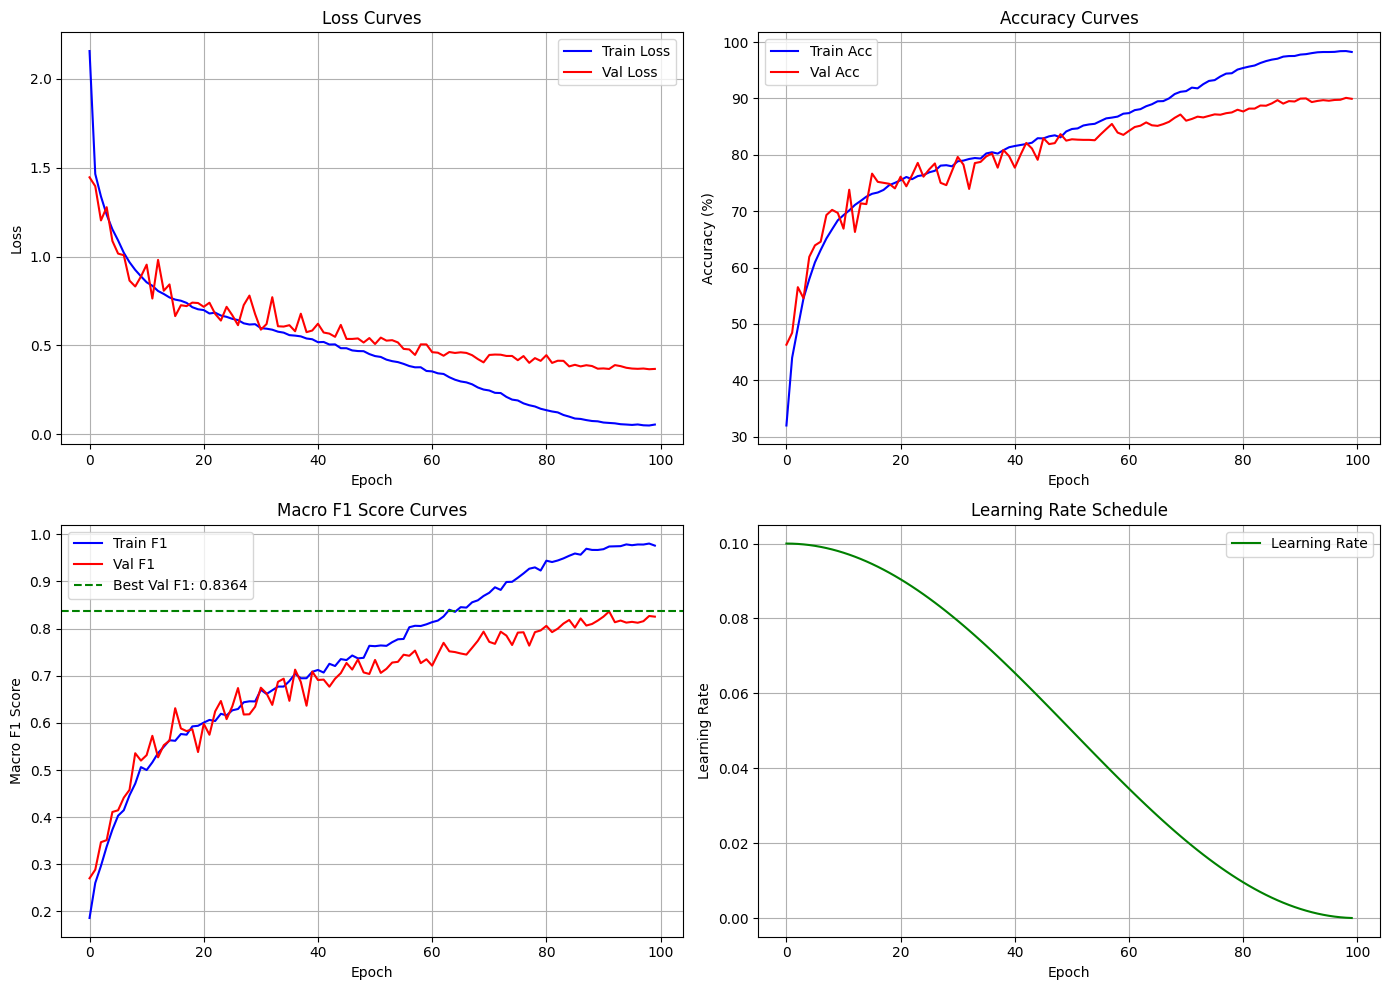

Training curves saved to training_curves.png


In [16]:
# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss
axes[0, 0].plot(history['train_loss'], label='Train Loss', color='blue')
axes[0, 0].plot(history['val_loss'], label='Val Loss', color='red')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Loss Curves')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Accuracy
axes[0, 1].plot(history['train_acc'], label='Train Acc', color='blue')
axes[0, 1].plot(history['val_acc'], label='Val Acc', color='red')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].set_title('Accuracy Curves')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Macro F1
axes[1, 0].plot(history['train_f1'], label='Train F1', color='blue')
axes[1, 0].plot(history['val_f1'], label='Val F1', color='red')
axes[1, 0].axhline(y=best_val_f1, color='green', linestyle='--', label=f'Best Val F1: {best_val_f1:.4f}')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Macro F1 Score')
axes[1, 0].set_title('Macro F1 Score Curves')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Learning Rate
axes[1, 1].plot(history['lr'], label='Learning Rate', color='green')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Learning Rate')
axes[1, 1].set_title('Learning Rate Schedule')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
plt.show()
print("Training curves saved to training_curves.png")

## 6. Evaluation on Validation Set (Best Model)

Classification Report (Validation Set):
              precision    recall  f1-score   support

    airplane     0.9168    0.9566    0.9363       507
  automobile     0.9839    0.9899    0.9869       493
        bird     0.9146    0.8964    0.9054       502
         cat     0.8148    0.8534    0.8337       464
        deer     0.9178    0.9241    0.9210       435
         dog     0.8642    0.8317    0.8476       398
        frog     0.7353    0.5814    0.6494        43
       horse     0.7674    0.7021    0.7333        47
        ship     0.9333    0.7368    0.8235        38
       truck     0.8889    0.6154    0.7273        13

    accuracy                         0.9000      2940
   macro avg     0.8737    0.8088    0.8364      2940
weighted avg     0.8997    0.9000    0.8992      2940


*** Validation Macro F1 Score: 0.8364 ***


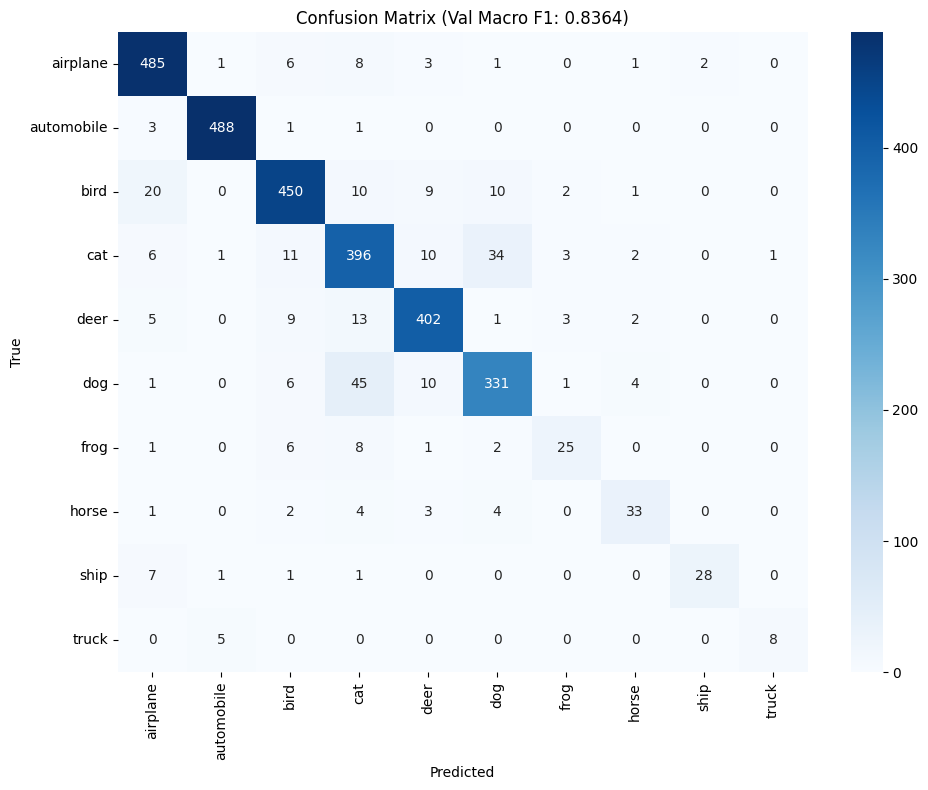

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Evaluate on validation set
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels, _ in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Classification report
print("Classification Report (Validation Set):")
print("=" * 60)
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

# Final Macro F1
final_macro_f1 = f1_score(all_labels, all_preds, average='macro')
print(f"\n*** Validation Macro F1 Score: {final_macro_f1:.4f} ***")

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix (Val Macro F1: {final_macro_f1:.4f})')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Retrain on Full Training Data

Now retrain the model on the **entire** training set (no validation split) using the same hyperparameters, to maximize performance for the final submission.

In [18]:
# Retrain on the full training set for final submission
print("Retraining on full training data for final submission...")

# Create full training dataset and loader
full_train_dataset = ShiftGuardDataset(train_dir, train_labels, label_to_idx, train_transform)
full_train_loader = DataLoader(full_train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                               num_workers=2, pin_memory=True)

# Re-initialize model from scratch
final_model = ShiftGuardCNN(num_classes=10).to(device)

# Same optimizer & scheduler
final_optimizer = optim.SGD(final_model.parameters(), lr=LEARNING_RATE,
                            momentum=MOMENTUM, weight_decay=WEIGHT_DECAY, nesterov=True)
final_scheduler = optim.lr_scheduler.CosineAnnealingLR(final_optimizer, T_max=NUM_EPOCHS, eta_min=1e-5)

# Train on full data
for epoch in range(1, NUM_EPOCHS + 1):
    final_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels, _ in full_train_loader:
        images, labels = images.to(device), labels.to(device)
        
        final_optimizer.zero_grad()
        outputs = final_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        final_optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    final_scheduler.step()
    
    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    
    if epoch % 10 == 0 or epoch == 1 or epoch == NUM_EPOCHS:
        current_lr = final_optimizer.param_groups[0]['lr']
        print(f"Epoch [{epoch:3d}/{NUM_EPOCHS}] | LR: {current_lr:.6f} | "
              f"Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.2f}%")

# Save final model
torch.save(final_model.state_dict(), 'final_model.pth')
print("\nFull training complete! Final model saved.")

Retraining on full training data for final submission...
Epoch [  1/100] | LR: 0.099975 | Loss: 2.0747 | Acc: 32.79%
Epoch [ 10/100] | LR: 0.097553 | Loss: 0.8642 | Acc: 68.90%
Epoch [ 20/100] | LR: 0.090452 | Loss: 0.6931 | Acc: 75.55%
Epoch [ 30/100] | LR: 0.079391 | Loss: 0.6094 | Acc: 78.28%
Epoch [ 40/100] | LR: 0.065454 | Loss: 0.5298 | Acc: 81.12%
Epoch [ 50/100] | LR: 0.050005 | Loss: 0.4516 | Acc: 84.05%
Epoch [ 60/100] | LR: 0.034556 | Loss: 0.3566 | Acc: 87.59%
Epoch [ 70/100] | LR: 0.020619 | Loss: 0.2649 | Acc: 90.62%
Epoch [ 80/100] | LR: 0.009558 | Loss: 0.1544 | Acc: 94.59%
Epoch [ 90/100] | LR: 0.002457 | Loss: 0.0700 | Acc: 97.66%
Epoch [100/100] | LR: 0.000010 | Loss: 0.0518 | Acc: 98.32%

Full training complete! Final model saved.


## 8. Generate Test Predictions & Submission CSV

In [19]:
# Generate predictions on the test set using the final model
final_model.eval()

test_ids = []
test_preds = []

with torch.no_grad():
    for images, img_ids in test_loader:
        images = images.to(device)
        outputs = final_model(images)
        _, predicted = outputs.max(1)
        
        test_ids.extend(img_ids.numpy())
        test_preds.extend(predicted.cpu().numpy())

# Convert predictions to class names
pred_labels = [idx_to_label[p] for p in test_preds]

# Create submission DataFrame
submission = pd.DataFrame({
    'id': test_ids,
    'label': pred_labels
})

# Sort by id to match sample_submission format
submission = submission.sort_values('id').reset_index(drop=True)

# Format id column to match sample_submission (6-digit zero-padded string)
# Check sample_submission format first
sample_sub = pd.read_csv(src_dir + 'sample_submission.csv')
print("Sample submission format:")
print(sample_sub.head())
print(f"\nSample submission id dtype: {sample_sub['id'].dtype}")

# Match the id format from sample_submission
if sample_sub['id'].dtype == object:
    submission['id'] = submission['id'].apply(lambda x: f'{x:06d}')
    
print(f"\nOur submission format:")
print(submission.head())
print(f"\nSubmission shape: {submission.shape}")
print(f"Unique labels predicted: {submission['label'].nunique()}")
print(f"Prediction distribution:")
print(submission['label'].value_counts().sort_index())

Sample submission format:
   id     label
0   1  airplane
1   2  airplane
2   3  airplane
3   4  airplane
4   5  airplane

Sample submission id dtype: int64

Our submission format:
   id       label
0   1  automobile
1   2  automobile
2   3         dog
3   4        frog
4   5         dog

Submission shape: (7600, 2)
Unique labels predicted: 10
Prediction distribution:
label
airplane      785
automobile    986
bird          676
cat           810
deer          958
dog           867
frog          708
horse         686
ship          752
truck         372
Name: count, dtype: int64


## 9. Test Set Prediction Analysis

Since test labels are not available, we analyze prediction confidence and distribution to verify model behavior.

TEST SET PREDICTION ANALYSIS

Prediction Confidence Statistics:
  Mean confidence: 0.9140
  Std confidence:  0.1500
  Min confidence:  0.2160
  Max confidence:  1.0000
  Median confidence: 0.9951

Confidence Distribution:
  >= 50%: 97.0% of predictions
  >= 70%: 87.8% of predictions
  >= 80%: 82.2% of predictions
  >= 90%: 75.4% of predictions
  >= 95%: 68.9% of predictions

Prediction Distribution (Test vs Train):
----------------------------------------
            Train %  Test Pred %
airplane       17.0         10.3
automobile     17.0         13.0
bird           17.0          8.9
cat            17.0         10.7
deer           13.6         12.6
dog            13.6         11.4
frog            1.7          9.3
horse           1.7          9.0
ship            1.0          9.9
truck           0.3          4.9


/tmp/ipython-input-3632625061.py:91: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(class_names, rotation=45, ha='right')


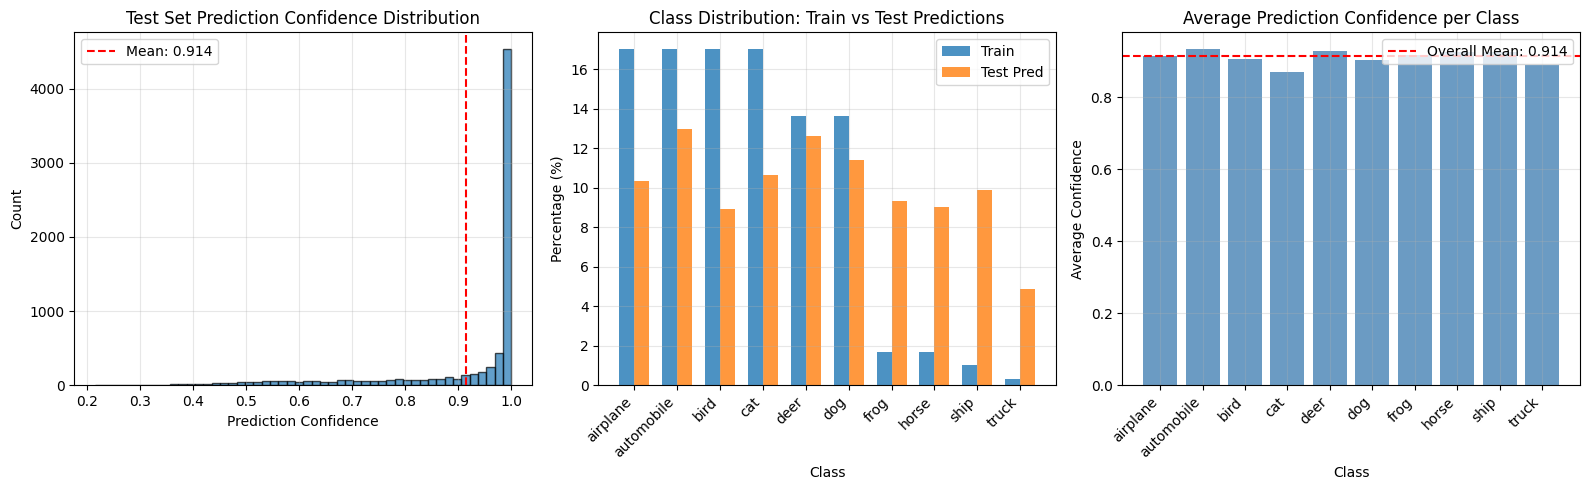


Note: True test metrics (F1, accuracy) cannot be computed
because test labels are hidden for competition fairness.
The validation Macro F1 is the best estimate of test performance.
Validation Macro F1: 0.8364


In [21]:
# Analyze test predictions - confidence and distribution
final_model.eval()

test_confidences = []
test_predictions = []
test_probs_all = []

with torch.no_grad():
    for images, img_ids in test_loader:
        images = images.to(device)
        outputs = final_model(images)
        probs = F.softmax(outputs, dim=1)
        confidence, predicted = probs.max(1)
        
        test_confidences.extend(confidence.cpu().numpy())
        test_predictions.extend(predicted.cpu().numpy())
        test_probs_all.extend(probs.cpu().numpy())

test_confidences = np.array(test_confidences)
test_predictions = np.array(test_predictions)
test_probs_all = np.array(test_probs_all)

# Confidence statistics
print("=" * 60)
print("TEST SET PREDICTION ANALYSIS")
print("=" * 60)
print(f"\nPrediction Confidence Statistics:")
print(f"  Mean confidence: {test_confidences.mean():.4f}")
print(f"  Std confidence:  {test_confidences.std():.4f}")
print(f"  Min confidence:  {test_confidences.min():.4f}")
print(f"  Max confidence:  {test_confidences.max():.4f}")
print(f"  Median confidence: {np.median(test_confidences):.4f}")

# Confidence distribution by threshold
print(f"\nConfidence Distribution:")
for thresh in [0.5, 0.7, 0.8, 0.9, 0.95]:
    pct = (test_confidences >= thresh).mean() * 100
    print(f"  >= {thresh:.0%}: {pct:.1f}% of predictions")

# Prediction distribution comparison
print(f"\nPrediction Distribution (Test vs Train):")
print("-" * 40)
train_dist = train_labels['label'].value_counts(normalize=True).sort_index()
test_pred_labels = [idx_to_label[p] for p in test_predictions]
test_dist = pd.Series(test_pred_labels).value_counts(normalize=True).sort_index()

comparison_df = pd.DataFrame({
    'Train %': (train_dist * 100).round(1),
    'Test Pred %': (test_dist * 100).round(1)
})
print(comparison_df)

# Visualizations
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Confidence histogram
axes[0].hist(test_confidences, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=test_confidences.mean(), color='red', linestyle='--', 
                label=f'Mean: {test_confidences.mean():.3f}')
axes[0].set_xlabel('Prediction Confidence')
axes[0].set_ylabel('Count')
axes[0].set_title('Test Set Prediction Confidence Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Class distribution comparison
x = np.arange(len(class_names))
width = 0.35
axes[1].bar(x - width/2, train_dist.values * 100, width, label='Train', alpha=0.8)
axes[1].bar(x + width/2, test_dist.values * 100, width, label='Test Pred', alpha=0.8)
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Percentage (%)')
axes[1].set_title('Class Distribution: Train vs Test Predictions')
axes[1].set_xticks(x)
axes[1].set_xticklabels(class_names, rotation=45, ha='right')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. Per-class average confidence
class_confidences = {name: [] for name in class_names}
for pred, conf in zip(test_predictions, test_confidences):
    class_confidences[idx_to_label[pred]].append(conf)
avg_conf_per_class = [np.mean(class_confidences[name]) for name in class_names]

axes[2].bar(class_names, avg_conf_per_class, color='steelblue', alpha=0.8)
axes[2].axhline(y=test_confidences.mean(), color='red', linestyle='--', 
                label=f'Overall Mean: {test_confidences.mean():.3f}')
axes[2].set_xlabel('Class')
axes[2].set_ylabel('Average Confidence')
axes[2].set_title('Average Prediction Confidence per Class')
axes[2].set_xticklabels(class_names, rotation=45, ha='right')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('test_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "=" * 60)
print("Note: True test metrics (F1, accuracy) cannot be computed")
print("because test labels are hidden for competition fairness.")
print("The validation Macro F1 is the best estimate of test performance.")
print(f"Validation Macro F1: {final_macro_f1:.4f}")
print("=" * 60)

In [20]:
# Save submission CSV
submission.to_csv('submission.csv', index=False)
print("Submission CSV saved to 'submission.csv'")

# Verify submission format matches sample
print("\n--- Submission Verification ---")
saved_sub = pd.read_csv('submission.csv')
print(f"Columns: {list(saved_sub.columns)}")
print(f"Number of rows: {len(saved_sub)}")
print(f"Expected rows (from sample): {len(sample_sub)}")
print(f"All labels valid: {all(l in class_names for l in saved_sub['label'].values)}")
print(f"\nFirst 5 rows:")
print(saved_sub.head())
print(f"\nLast 5 rows:")
print(saved_sub.tail())
print("\n✓ Submission file is ready for upload!")

Submission CSV saved to 'submission.csv'

--- Submission Verification ---
Columns: ['id', 'label']
Number of rows: 7600
Expected rows (from sample): 7600
All labels valid: True

First 5 rows:
   id       label
0   1  automobile
1   2  automobile
2   3         dog
3   4        frog
4   5         dog

Last 5 rows:
        id     label
7595  7596  airplane
7596  7597  airplane
7597  7598      ship
7598  7599     horse
7599  7600       dog

✓ Submission file is ready for upload!
